In this notebook we will explain the RIPPL workflow based on a study case about the Kumamoto earthquake in 
Japan. 

In the first block we define the study area. There are different options to do so.
1. Create a shapefile (this can be done using ArcGIS or QGIS software)
2. Create a kml file using google earth > https://www.google.com/earth/
3. Create a geojson using > http://geojson.io
4. Create a list of coordinates in lat/lon coordinate pairs. This is what we will do here. 

To show the study area it is possible to run both google earth and geojson within the notebook.

For further background on this event you can read:
https://en.wikipedia.org/wiki/2016_Kumamoto_earthquakes

Following image shows the earthquake strength (credits: USGS 2016):
![Image of Kumamoto earthquake strength](https://upload.wikimedia.org/wikipedia/commons/1/14/Japan_Shakemap_15_April_2016.jpg)

In [10]:
# Import script to embed geolocation.
from rippl.orbit_geometry.read_write_shapes import ReadWriteShapes

coordinates = [(130.25, 32.28), (131.35, 32.28), (131.35, 33.24), (130.25, 33.24), (130.25, 32.28)]
study_area = ReadWriteShapes()
study_area(coordinates)

geojson = study_area.shape

The next step in the processing is selection of the right track, as the Sentinel-1 satellite will cover the area on both
ascending and descending tracks. However, to do so, we will have to define the start and end date of our data search,
because the satellite is not always acquiring data.
Next search will give a small oversight of the available tracks during our period of interest. In our case we will
search one week before and one week after the earthquake.

Watch out with extending the search window, this can result in a lot of images. For now, the total number of images
in this software is limited to a 100. Also note that every downloaded file will take approximately 4GB of disk space!

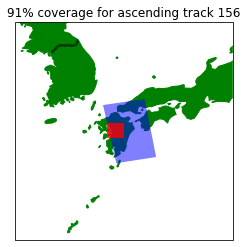

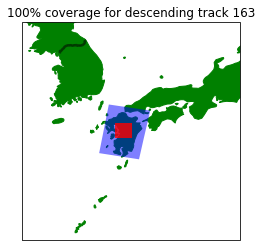

Summary statistics for Sentinel-1 search:
Stack for ascending track 156 contains 2 images with 91% coverage of area of interest
Stack for descending track 163 contains 1 images with 100% coverage of area of interest

Full list of images for track 156:
2016-04-08T09:14:30 with a coverage of 91% consists of SAR products:
          S1A_IW_SLC__1SSV_20160408T091355_20160408T091430_010728_01001F_83EB
          S1A_IW_SLC__1SSV_20160408T091327_20160408T091357_010728_01001F_819A
2016-04-20T09:14:23 with a coverage of 91% consists of SAR products:
          S1A_IW_SLC__1SSV_20160420T091355_20160420T091423_010903_010569_F9CE
          S1A_IW_SLC__1SSV_20160420T091328_20160420T091358_010903_010569_76E1

Full list of images for track 163:
2016-04-20T21:17:23 with a coverage of 100% consists of SAR products:
          S1A_IW_SLC__1SSV_20160420T211656_20160420T211723_010910_01059E_F15F
          S1A_IW_SLC__1SSV_20160420T211630_20160420T211658_010910_01059E_8779


In [11]:
from rippl.SAR_sensors.sentinel.sentinel_download import DownloadSentinel
import datetime

# start_date = datetime.datetime(year=2016, month=4, day=7)
# end_date = datetime.datetime(year=2016, month=4, day=21)
dates = [datetime.datetime(year=2016, month=4, day=14)]
time_window = datetime.timedelta(days=10)
polarisation = 'VV'
mode = 'IW'
product_type = 'SLC'

find_track = DownloadSentinel(dates=dates, time_window=time_window, shape=study_area.shape, sensor_mode=mode, polarisation=polarisation)
find_track.sentinel_search_ASF()
find_track.sentinel_search_ESA()
find_track.summarize_search_results()

After selection of the right track we can start the actual download of the images. In our case we use track 156 in the
descending/ascending direction.

This will download our data automatically to our radar database. Additionally, it will download the precise orbit files.
These files are created within a few weeks after the data acquisition and define the satellite orbit within a few cm
accuracy. These orbits are necessary to accurately define the positions of the radar pixels on the ground later on
in the processing.

In [3]:
from rippl.processing_templates.general_sentinel_1 import GeneralPipelines

master_date = datetime.datetime(year=2016, month=4, day=8)
track = 156
stack_name = 'Kumamoto_earthquake'

# Number of processes for parallel processing. Make sure that for every process at least 3GB of RAM is available
no_processes = 4

s1_processing = GeneralPipelines(processes=no_processes)
s1_processing.download_sentinel_data(dates=dates, time_window=time_window, track=track,
                                           polarisation=polarisation, shapefile=study_area.shape, data=True)
s1_processing.create_sentinel_stack(dates=dates, time_window=time_window, master_date=master_date,
                                          track=track,stack_name=stack_name, polarisation=polarisation,
                                          shapefile=study_area.shape, mode=mode, product_type=product_type)

# Finally load the stack itself. If you want to skip the download step later, run this line before other steps!
s1_processing.read_stack(dates=dates, time_window=time_window, stack_name=stack_name)

Loading available orbit data files
Finished loading date files
S1B_IW_SLC__1SDV_20180423T172430_20180423T172457_010614_0135E1_3F2D.zip
S1B_IW_SLC__1SDV_20180423T172405_20180423T172432_010614_0135E1_0C40.zip
S1A_IW_SLC__1SDV_20180417T172454_20180417T172521_021510_0250F2_04F0.zip
S1A_IW_SLC__1SDV_20180417T172519_20180417T172546_021510_0250F2_DE22.zip
Selected images:
S1B_IW_SLC__1SDV_20180423T172430_20180423T172457_010614_0135E1_3F2D.zip
S1B_IW_SLC__1SDV_20180423T172405_20180423T172432_010614_0135E1_0C40.zip
S1A_IW_SLC__1SDV_20180417T172454_20180417T172521_021510_0250F2_04F0.zip
S1A_IW_SLC__1SDV_20180417T172519_20180417T172546_021510_0250F2_DE22.zip

Reading precise and restituted orbit database
Reading swath .xml files for new images:
Read meta_data s1b-iw1-slc-vv-20180423t172432-20180423t172457-010614-0135e1-004.xml
Read meta_data s1b-iw2-slc-vv-20180423t172430-20180423t172455-010614-0135e1-005.xml
Read meta_data s1b-iw3-slc-vv-20180423t172431-20180423t172456-010614-0135e1-006.xml
Read

To define the location of the radar pixels on the ground we need the terrain elevation. Although it is possible to
derive terrain elevation from InSAR data, our used Sentinel-1 dataset is not suitable for this purpose. Therefore, we
download data from an external source to create a digital elevation model (DEM). In our case we use SRTM data.

However, to find the elevation of the SAR data grid, we have to resample the data to the radar grid first to make it
usable. This is done in the next steps.

In [4]:
# Some basic settings for DEM creation.
dem_buffer = 1        # Buffer around radar image where DEM data is downloaded
dem_rounding = 1      # Rounding of DEM size in degrees
dem_type = 'SRTM3'      # DEM type of data we download (SRTM1, SRTM3 and TanDEM-X are supported)

# Define both the coordinate system of the full radar image and imported DEM
s1_processing.create_radar_coordinates()
s1_processing.create_dem_coordinates(dem_type=dem_type)

# Download external DEM
s1_processing.download_external_dem(buffer=dem_buffer, rounding=dem_rounding)

Using the obtained elevation model the exact location of the radar pixels in cartesian (X,Y,Z) and geographic (Lat/Lon)
can be derived. This is only done for the master or reference image. This process is referred to as geocoding.

In [5]:
# Geocoding of image
s1_processing.geocoding(dem_buffer=0.1, dem_rounding=0.1, block_orientation='blocks')

Processing pipeline block 1 out of 1
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 1 out of 1
Finished concatenation dem of /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Netherlands/20180417
Finished concatenation dem of /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Netherlands/20180417
Finished concatenation geocode of /Users/gertmulder/SAR_pr

The information from the geocoding can directly be used to find the location of the master grid pixels in the slave
grid images. This process is called coregistration. Because the orbits are not exactly the same with every satellite
overpass but differ hundreds to a few thousand meters every overpass, the grids are slightly shifted with respect to
each other. These shift are referred to as the spatial baseline of the images. To correctly overlay the master and slave
images the software coregisters and resamples to the master grid.

To do so the following steps are done:
1. Coregistration of slave to master image
2. Deramping the doppler effects due to TOPs mode of Sentinel-1 satellite
3. Resampling of slave image
4. Reramping resampled slave image.

Due to the different orbits of the master and slave image, the phase of the radar signal is also shifted. We do not
know the exact shift of the two image, but using the geometry of the two images we can estimate the shift of the phase
between different pixels. Often this shift is split in two contributions:
1. The flat earth phase. This phase is the shift in the case the earth was a perfect ellipsoid
2. The topographic phase. This is the phase shift due to the topography on the ground.
In our processing these two corrections are done in one go.

In [6]:
# Next step applies resampling and phase correction in one step.
# Polarisation
s1_processing.geometric_coregistration_resampling(polarisation=polarisation, output_phase_correction=False, block_orientation='blocks')

Processing pipeline block 1 out of 2
Processing pipeline block 2 out of 2
Finished concatenation calc_reramp of /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Netherlands/20180417
Finished concatenation correct_phases of /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Netherlands/20180417
Finished concatenation calc_reramp of /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Netherlands/20180423
Finished concatenation correct_phases of /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Netherlands/20180423


Before we create an interferogram the different bursts are first mosaicked. This can only be done after resampling as
it is influenced by the phase ramps in TOPs mode of Sentinel-1.

The independent SAR grids can now be visualized using the amplitude of the resampled data. In our case these are
written as .tiff files for a georeferenced grid of the region. The data can be visualized using QGIS. The amplitude power
is given in dB.

In [7]:
# Select whether you want a geographic or equidistant grid as output. If you want both, you can run all the processing
# blocks till the end with geographic True and False
geographic = False

if geographic:
    # Resolution of output georeferenced grid
    dlat = 0.001
    dlon = 0.001

    # The actual creation of the calibrated amplitude images
    s1_processing.create_ml_coordinates(standard_type='geographic', dlat=dlat, dlon=dlon, buffer=0, rounding=0)
else:
    # Otherwise we create an oblique mercator grid which respects the azimuth and range directions and generates a grid
    # with equal pixel size in square meters (for degrees this can vary)
    dx = 100
    dy = 100

    # Create the multilooking grid
    s1_processing.create_ml_coordinates(standard_type='oblique_mercator', dx=dx, dy=dy, buffer=0, rounding=0)

s1_processing.prepare_multilooking_grid(polarisation, block_orientation='blocks')
s1_processing.create_calibrated_amplitude_multilooked(polarisation)
s1_processing.create_output_tiffs_amplitude()

Finished concatenation crop of /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Netherlands/20180417
Processing pipeline block 1 out of 1
Processing pipeline block 1 out of 1
Processing 0 out of 46
Processing 1 out of 46
Processing 2 out of 46
Processing 3 out of 46
Processing 4 out of 46
Processing 5 out of 46
Processing 6 out of 46
Processing 7 out of 46
Processing 8 out of 46
Processing 9 out of 46
Processing 10 out of 46
Processing 11 out of 46
Processing 12 out of 46
Processing 13 out of 46
Processing 14 out of 46
Processing 15 out of 46
Processing 16 out of 46
Processing 17 out of 46
Processing 18 out of 46
Processing 19 out of 46
Processing 20 out of 46
Processing 21 out of 46
Processing 22 out of 46
Processing 23 out of 46
Processing 24 out of 46
Processing 25 out of 46
Processing 26 out of 46
Processing 27 out of 46
Processing 28 out of 46
Processing 29 out of 46
Processing 30 out of 46
Processing 31 out of 46
Processing 32 out of 46
Processing 33 out of 46
Process

After moasicing we can create the interferogram between the different images. This image is also multilooked and
outputted as a .tiff file. This can also be viewed in QGIS. Because the phase shift between different pixels is often
larger than two pi radians or a wavelength (56 mm for C-band), this image will show fringes going from -pi to pi and
starting at -pi again.
Using the same multilooking grid also a coherence grid is created, which indicates the quality of the obtained phases.

In [8]:
s1_processing.create_ifg_network(temporal_baseline=30)
s1_processing.create_interferogram_multilooked(polarisation)
s1_processing.create_coherence_multilooked(polarisation)

# Create output geotiffs
s1_processing.create_output_tiffs_coherence_ifg()

# Create lat/lon/incidence angle/DEM for multilooked grid.
s1_processing.create_geometry_mulitlooked()
s1_processing.create_output_tiffs_geometry()

Processing pipeline block 1 out of 1
Processing pipeline block 1 out of 1
Processing 0 out of 46
Processing 1 out of 46
Processing 2 out of 46
Processing 3 out of 46
Processing 4 out of 46
Processing 5 out of 46
Processing 6 out of 46
Processing 7 out of 46
Processing 8 out of 46
Processing 9 out of 46
Processing 10 out of 46
Processing 11 out of 46
Processing 12 out of 46
Processing 13 out of 46
Processing 14 out of 46
Processing 15 out of 46
Processing 16 out of 46
Processing 17 out of 46
Processing 18 out of 46
Processing 19 out of 46
Processing 20 out of 46
Processing 21 out of 46
Processing 22 out of 46
Processing 23 out of 46
Processing 24 out of 46
Processing 25 out of 46
Processing 26 out of 46
Processing 27 out of 46
Processing 28 out of 46
Processing 29 out of 46
Processing 30 out of 46
Processing 31 out of 46
Processing 32 out of 46
Processing 33 out of 46
Processing 34 out of 46
Processing 35 out of 46
Processing 36 out of 46
Processing 37 out of 46
Processing 38 out of 46


/Users/gertmulder/software/rippl_development/rippl/meta_data/image_data.py:418: RuntimeWarning: divide by zero encountered in log
  data.GetRasterBand(1).WriteArray(np.log(np.abs(self.memory['data'])))


To go to absolute differences the data is therefore unwrapped. The result of this is given in the unwrapped geotiff.

In [9]:
# To do the unwrapping, we should add a filter step, which is not included in the package at the moment....
# You can do the unwrapping if you change resolution of the image though.
s1_processing.create_unwrapped_images(polarisation)
s1_processing.create_output_tiffs_unwrap()

Processing pipeline block 1 out of 1


This finishes the tutorial!